# Poisson Distribution

We can look to model the goals scored by each team as a Poisson Distribution

Can then see if we can use these 'predicted goals' as a way to predict final match outcomes

## 1. Imports

Import both the libs and the data required

In [114]:
from IPython.display import display, Latex, Markdown

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import poisson
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

pd.options.display.max_columns = None
pd.options.display.max_rows = 100
warnings.filterwarnings('ignore')

In [77]:
try:
    df = pd.read_pickle('feature_df')
except:
    print('feature_df is not defined yet')

## 2. Check Validity of the Poisson Distribution

Before fitting a poisson log-linear GLM we need to check if:
 - Goals per footie game can be modelled as a poisson process
 - The computed $\lambda$ params are stable throughout the feature space i.e. through time, across leagues etc

### 2a. Check Mean Goals Through Time

Compute the mean goals per team (per game) throughout the last 20 seasons

In [133]:
# only get cols we need
df_goal = df[['Season', 'FTHG', 'FTAG']]
# melt FTHG & FTAG into one col with {HomeAway, Goals}
df_goal = pd.melt(df_goal, id_vars=['Season'], value_name='Goals', value_vars=['FTHG', 'FTAG'], var_name='HomeAway')
df_goal['HomeAway'] = df_goal['HomeAway'].map({'FTHG': 'Home', 'FTAG': 'Away'})
df_goal.tail()

,Season,HomeAway,Goals
12811,2020/2021,Away,6.0
12812,2020/2021,Away,0.0
12813,2020/2021,Away,1.0
12814,2020/2021,Away,0.0
12815,2020/2021,Away,3.0


Season,2003/2004,2004/2005,2005/2006,2006/2007,2007/2008,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016,2016/2017,2017/2018,2018/2019,2019/2020,2020/2021
HomeAway,,,,,,,,,,,,,,,,,,
Away,1.143284,1.071642,1.023684,0.997368,1.107895,1.078947,1.073684,1.173684,1.215789,1.239474,1.194737,1.092105,1.207895,1.202632,1.147368,1.252632,1.205263,2.026316
Home,1.492537,1.468657,1.460526,1.452632,1.528947,1.400000,1.697368,1.623684,1.589474,1.557895,1.573684,1.473684,1.492105,1.597368,1.531579,1.568421,1.515789,1.763158


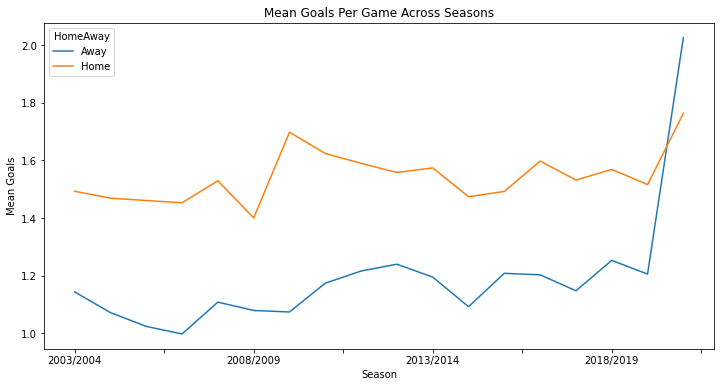

In [137]:
df_avg_goal = pd.pivot_table(df_goal.groupby(['Season', 'HomeAway']).mean(), index='HomeAway', columns='Season', values='Goals')
display(df_avg_goal)
df_avg_goal.T.plot(figsize=(12,6));
plt.title('Mean Goals Per Game Across Seasons');
plt.ylabel('Mean Goals');
plt.xlabel('Season');

Mean Goals per game per season looks fairly constant across time with home advantage also fairly constant - bump in most recent but only due to fire start to the season

### 2b. Fit Season Poisson Distributions

Based on the above, we now fit individual poisson distributions per season to identify if we have vastly different $\lambda$s per season

In [150]:
# var to store poisson pmfs
pmfs = []

# create goal & season range
goal_range = df_goal.Goals.unique()
season_range = df_goal.Season.unique()
# iterate for each season, HomeAway, goal
for s in season_range:
    for t in ['Home', 'Away']:
        
        # compute mean for poisson for that season, HomeAway
        avg = df_avg_goal.T[t][s]
        for g in goal_range:
            # compute prob
            p = poisson.pmf(g, avg)
            record = {'Season': s, 'HomeAway': t, 'Goals': g, 'Prob': p}
            pmfs.append(record)

# create df from the records
df_pmfs = pd.DataFrame.from_records(pmfs)

In [179]:
df_act_prob = df_goal.copy()
df_act_prob['ActProb'] = 1
df_act_prob = df_act_prob.groupby(['Season', 'HomeAway', 'Goals']).count() / df_act_prob[['Season', 'HomeAway', 'ActProb']].groupby(['Season', 'HomeAway']).count()
df_act_prob = df_act_prob.reset_index()
df_act_prob.tail()

,Season,HomeAway,Goals,ActProb
254,2020/2021,Home,2.0,0.157895
255,2020/2021,Home,3.0,0.078947
256,2020/2021,Home,4.0,0.157895
257,2020/2021,Home,5.0,0.026316
258,2020/2021,Home,7.0,0.026316


In [182]:
df_probs = pd.merge(left=df_pmfs, right=df_act_prob, how='left', on=['Season', 'HomeAway', 'Goals']).fillna(0)
df_probs = df_probs.sort_values(['Season', 'HomeAway', 'Goals'])
df_probs

,Season,HomeAway,Goals,Prob,ActProb
15,2003/2004,Away,0.0,0.318771,0.337313
13,2003/2004,Away,1.0,0.364445,0.334328
10,2003/2004,Away,2.0,0.208332,0.220896
11,2003/2004,Away,3.0,0.079394,0.068657
12,2003/2004,Away,4.0,0.022693,0.032836
...,...,...,...,...,...
344,2020/2021,Home,5.0,0.024353,0.026316
346,2020/2021,Home,6.0,0.007156,0.000000
347,2020/2021,Home,7.0,0.001803,0.026316
348,2020/2021,Home,8.0,0.000397,0.000000


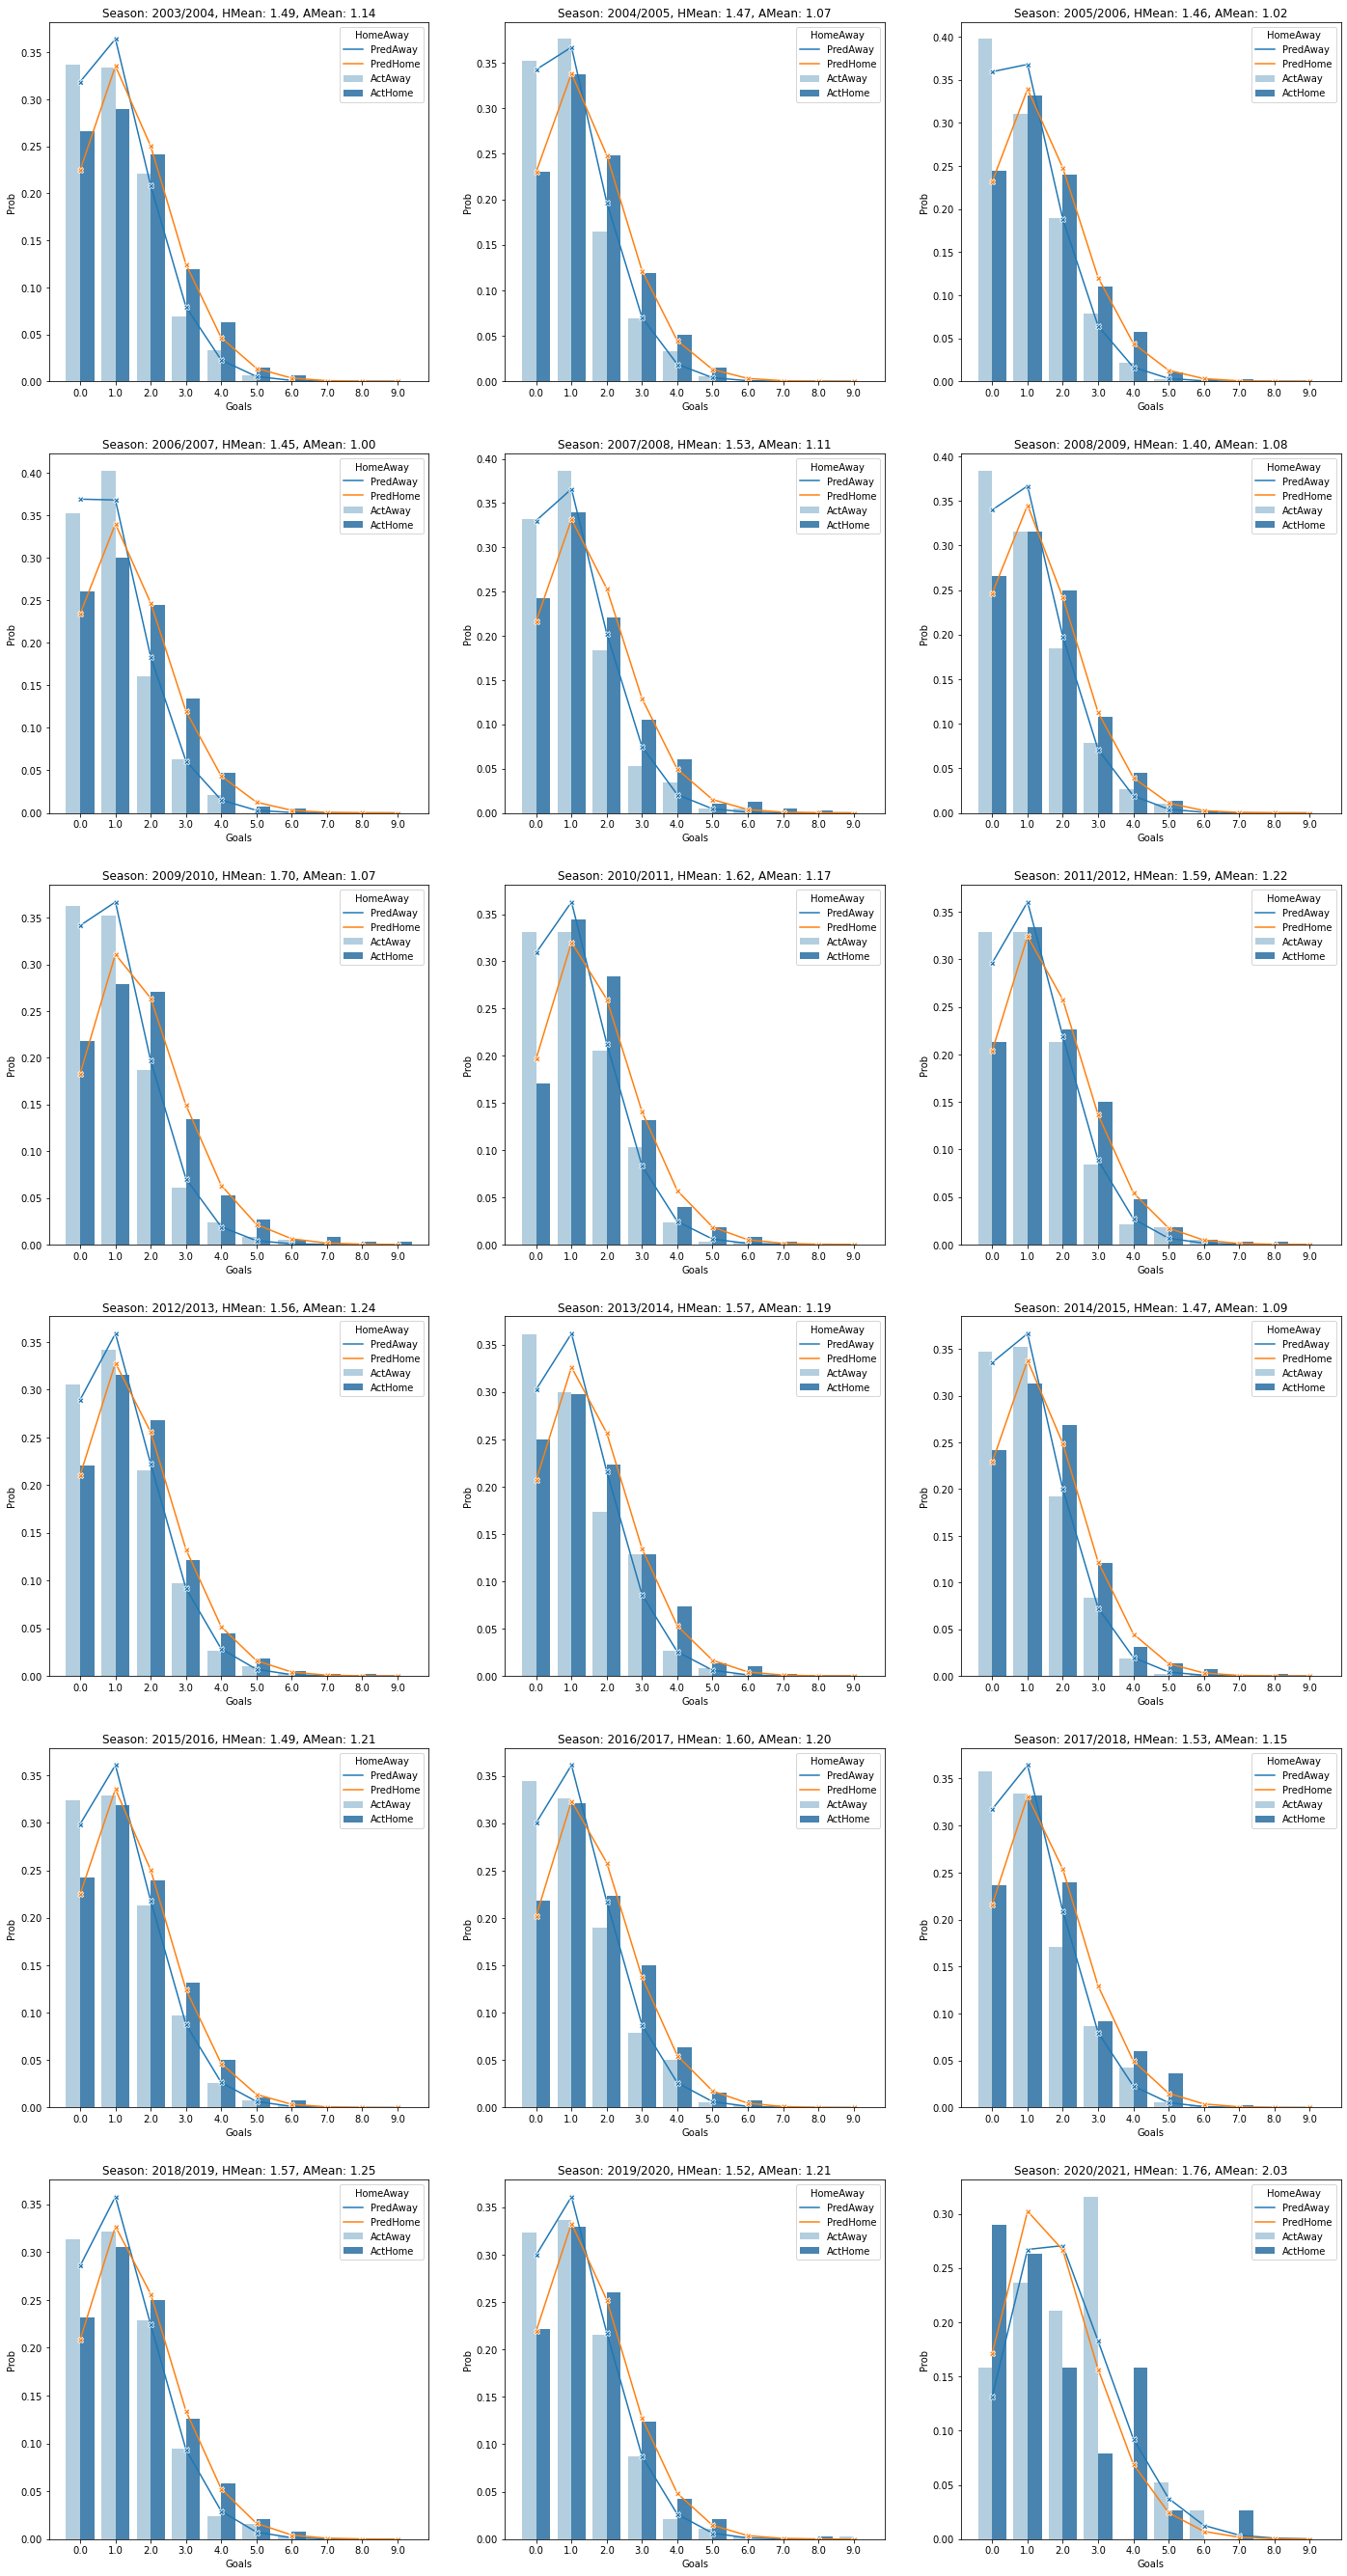

In [237]:
seasons = list(df_probs.Season.unique())
df_avgs = df_avg_goal.T

cols = 3
rows = len(seasons) / cols
rows = round(rows+0.5)
fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(8*cols, 8*rows))
ax = ax.reshape(-1)

for s in seasons:
    # select data
    df = df_probs[df_probs.Season == s]
    
    df_line = df.copy()
    df_line['HomeAway'] = df_line['HomeAway'].map({'Home': 'PredHome', 'Away': 'PredAway'})
    
    df_bar = df.copy()
    df_bar['HomeAway'] = df_bar['HomeAway'].map({'Home': 'ActHome', 'Away': 'ActAway'})
    
    # select axis
    a = ax[seasons.index(s)]
    # plot act and est distributions
    sns.barplot(data=df_bar, x='Goals', y='ActProb', hue='HomeAway', ax=a, palette='Blues');
    sns.lineplot(data=df_line, x='Goals', y='Prob', hue='HomeAway', marker='X', ax=a);
    
    hmean = df_avgs['Home'][s]
    amean = df_avgs['Away'][s]
    a.set_title('Season: {}, HMean: {:.2f}, AMean: {:.2f}'.format(s, hmean, amean));
    a.set_xlabel('Goals');
    a.set_ylabel('Prob');

Results look good:
 - Each season Home and Away goals look like they can be modelled reasonably well as a poisson distribution
 - Means are fairly consistent through time so don't need to worry too much about training length period i.e. nonstationarity in the model

Today To Do:
 - Write DB Creation & Maintainence scripts
  - Maintenance must be such that it can run whenever (every day / every week / once a month) and still work
  - Matches must be given keys s.t. the feature table can be joined on
  - New matches 